In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns


## Read Solar & UV Radiation file

In [2]:
# Read UV Radiation file
df_Ali_dist = pd.read_csv("UV-RS-Ali.csv", sep=";", engine="python")
# Will drop not needed columns: ID & Batt
df_Ali_dist.drop(['ID', 'Batt'], inplace=True, axis=1)
# Rename column to simpler name
df_Ali_dist.rename(columns={'RS-CM6-A': 'RS'}, inplace=True)
df_Ali_dist.head()


,Year,DOY,TIME,UV,RS
0,2015.0,295.0,840,16.78,387.1
1,2015.0,295.0,850,18.44,417.6
2,2015.0,295.0,900,20.22,449.3
3,2015.0,295.0,910,21.97,482.0
4,2015.0,295.0,920,23.65,511.6


In [3]:
# Prepare working dataframe

df_Ali_tmp = df_Ali_dist.copy()
# Convert DOY to date
df_Ali_tmp['nDate'] = pd.to_datetime(df_Ali_tmp['Year'] * 1000 + df_Ali_tmp['DOY'], format='%Y%j')

# Drop columns YEAR & DOY no longer needed
df_Ali_tmp.drop(['Year', 'DOY'], inplace=True, axis=1)

# Create nTime column %H:%M format
df_Ali_tmp['nTime'] = pd.to_datetime(df_Ali_tmp['TIME'], errors='coerce', format='%H%M').dt.strftime('%H:%M:%S')
df_Ali_tmp['nTime'] = pd.to_timedelta(df_Ali_tmp['nTime'], unit='H')

# Drop TIME columns no longer needed
df_Ali_tmp.drop(['TIME'], inplace=True, axis=1)

df_Ali_tmp.head()


,UV,RS,nDate,nTime
0,16.78,387.1,2015-10-22,08:40:00
1,18.44,417.6,2015-10-22,08:50:00
2,20.22,449.3,2015-10-22,09:00:00
3,21.97,482.0,2015-10-22,09:10:00
4,23.65,511.6,2015-10-22,09:20:00


In [27]:
# Prepare working dataframe
df_Ali_work = df_Ali_tmp.copy()
# Join nDate and nTime columns
df_Ali_work['Date'] = df_Ali_work['nDate'] +  df_Ali_work['nTime']
# Drop columns nDate and nTime no longer needed
df_Ali_work.drop(['nDate', 'nTime'], inplace=True, axis=1)

# Eliminate duplicates
N_before = df_Ali_work.shape[0]
df_Ali_work.drop_duplicates(keep=False, inplace=True)
N_after = df_Ali_work.shape[0]
print(N_before - N_after,' Duplicate rows droped from Ali')

# Drop rows with null: UV, RS-CM6-A
df_Ali_work = df_Ali_work.loc[~((df_Ali_work['UV'].isnull()))]
df_Ali_work = df_Ali_work.loc[~((df_Ali_work['RS'].isnull()))]

# Create Month, Day, Hour of day column
df_Ali_work['Month'] = df_Ali_work['Date'].dt.month
df_Ali_work['Day'] = df_Ali_work['Date'].dt.day
df_Ali_work['Hour'] = df_Ali_work['Date'].dt.hour

df_Ali = df_Ali_work.copy()

df_Ali.head()


12421  Duplicate rows droped from Ali


,UV,RS,Date,Month,Day,Hour
0,16.78,387.1,2015-10-22 08:40:00,10.0,22.0,8.0
1,18.44,417.6,2015-10-22 08:50:00,10.0,22.0,8.0
2,20.22,449.3,2015-10-22 09:00:00,10.0,22.0,9.0
3,21.97,482.0,2015-10-22 09:10:00,10.0,22.0,9.0
4,23.65,511.6,2015-10-22 09:20:00,10.0,22.0,9.0


In [5]:
# Filter year 2016 data
df_Ali_2016 = df_Ali[(df_Ali['Date'] > '2015-12-31 23:59:00' ) & (df_Ali['Date'] < '2016-12-31 23:59:00')]
print('df_Ali_2016.shape', df_Ali_2016.shape)
# Filter daylight data: 6AM - 6PM
df_Ali_2016_daytime = df_Ali_2016[(df_Ali_2016['Hour'] >= 6.0 ) & (df_Ali_2016['Hour'] <= 18.0)]
print('df_Ali_2016_daytime.shape', df_Ali_2016_daytime.shape)


df_Ali_2016.shape (46033, 6)
df_Ali_2016_daytime.shape (29934, 6)


In [7]:
# Compute Radiation values hourly averages
df_Ali_2016_daytime_Hourly_Avg = round(df_Ali_2016_daytime.groupby(['Month', 'Day', 'Hour']).aggregate(np.mean),2).reset_index()
print("\n Hourly Avg shape:", df_Ali_2016_daytime_Hourly_Avg.shape)
print(df_Ali_2016_daytime_Hourly_Avg.head())

# Group data by Month and Day
df_Ali_2016_daytime_Daily_Max = df_Ali_2016_daytime.groupby(["Month", "Day"])['UV', 'RS'].aggregate(np.max).reset_index()
print("\n Daily Max shape:", df_Ali_2016_daytime_Daily_Max.shape)
print(df_Ali_2016_daytime_Daily_Max.head())




 Hourly Avg shape: (4637, 5)
   Month  Day  Hour     UV      RS
0    1.0  1.0   6.0   0.00    0.00
1    1.0  1.0   7.0   0.49   12.93
2    1.0  1.0   8.0   5.14  153.12
3    1.0  1.0   9.0  12.66  342.72
4    1.0  1.0  10.0  16.86  427.34

 Daily Max shape: (357, 4)
   Month  Day     UV     RS
0    1.0  1.0  27.97  654.6
1    1.0  2.0  28.19  638.3
2    1.0  3.0  28.55  646.7
3    1.0  4.0  31.02  709.0
4    1.0  5.0  26.62  713.0


In [8]:
# Create monthly data
# January month 1
df_Ali_2016_Jan_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 1.0]
df_Ali_2016_Jan_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 1.0] 

# February month 2
df_Ali_2016_Feb_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 2.0]
df_Ali_2016_Feb_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 2.0] 

# March month 3
df_Ali_2016_Mar_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 3.0]
df_Ali_2016_Mar_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 3.0] 

# April month 4
df_Ali_2016_Apr_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 4.0]
df_Ali_2016_Apr_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 4.0] 

# May month 5
df_Ali_2016_May_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 5.0]
df_Ali_2016_May_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 5.0] 

# June month 6
df_Ali_2016_Jun_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 6.0]
df_Ali_2016_Jun_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 6.0] 

# July month 7
df_Ali_2016_Jul_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 7.0]
df_Ali_2016_Jul_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 7.0] 

# August month 8
df_Ali_2016_Aug_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 8.0]
df_Ali_2016_Aug_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 8.0] 

# September month 9
df_Ali_2016_Sep_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 9.0]
df_Ali_2016_Sep_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 9.0] 

# October month 10
df_Ali_2016_Oct_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 10.0]
df_Ali_2016_Oct_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 10.0] 

# November month 11
df_Ali_2016_Nov_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 11.0]
df_Ali_2016_Nov_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 11.0] 

# December month 12
df_Ali_2016_Dec_Hourly_Avg = df_Ali_2016_daytime_Hourly_Avg[df_Ali_2016_daytime_Hourly_Avg.Month == 12.0]
df_Ali_2016_Dec_Daily_Max = df_Ali_2016_daytime_Daily_Max[df_Ali_2016_daytime_Daily_Max.Month == 12.0] 



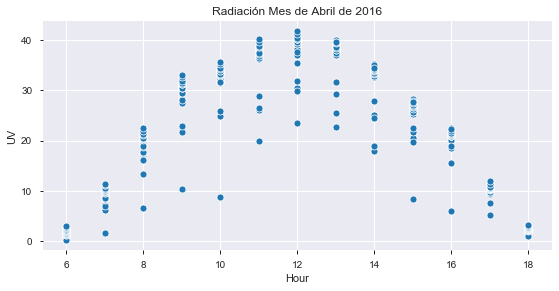

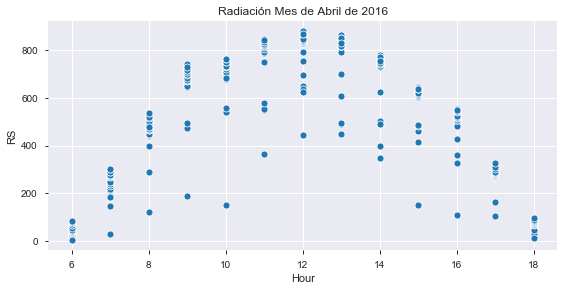

In [13]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

sns.pairplot(x_vars=['Hour'], y_vars=['UV'], data=df_Ali_2016_Apr_Hourly_Avg, height=4, aspect=2)
plt.title("Radiación Mes de Abril de 2016")
sns.pairplot(x_vars=['Hour'], y_vars=['RS'], data=df_Ali_2016_Apr_Hourly_Avg, height=4, aspect=2)
plt.title("Radiación Mes de Abril de 2016")
plt.show()


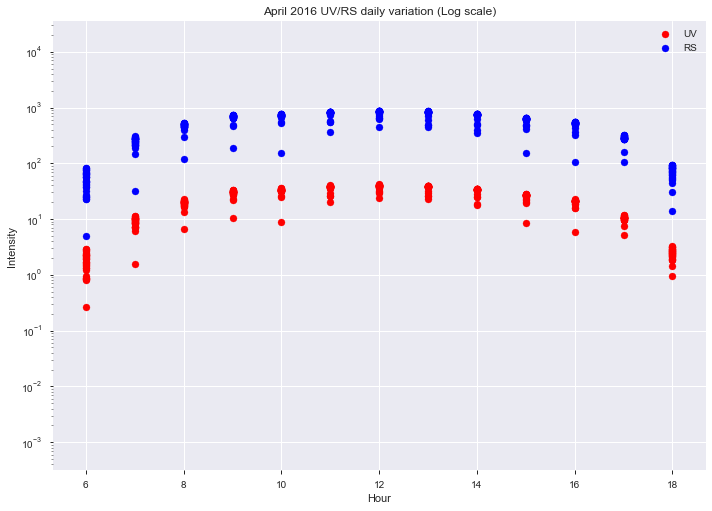

In [15]:
# matplotlib plot
import matplotlib.pyplot as pyplot

a= df_Ali_2016_Apr_Hourly_Avg.Hour
b= df_Ali_2016_Apr_Hourly_Avg.UV
c= df_Ali_2016_Apr_Hourly_Avg.RS

pyplot.yscale('log')
pyplot.scatter(a,b,label='UV',color='r')
pyplot.scatter(a,c,label='RS',color='b')
pyplot.xlabel('Hour')
pyplot.ylabel('Intensity')
pyplot.title('April 2016 UV/RS daily variation (Log scale)')
pyplot.legend()
pyplot.show()

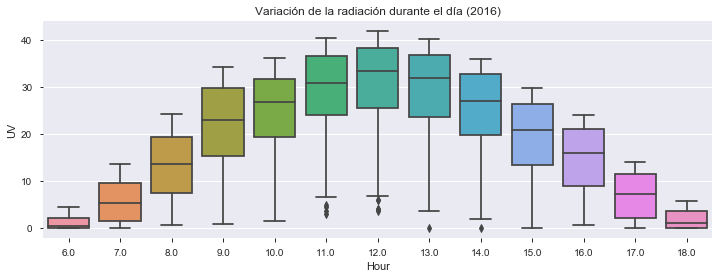

In [16]:
df = df_Ali_2016_daytime_Hourly_Avg

fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='Hour',y='UV',data=df,ax=ax)
plt.title("Variación de la radiación durante el día (2016)")
plt.show()


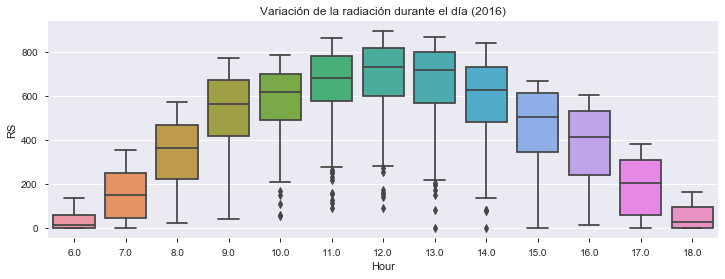

In [17]:
df = df_Ali_2016_daytime_Hourly_Avg

fig, ax = plt.subplots()
fig.set_size_inches((12,4))
plt.title("Variación de la radiación durante el día (2016)")
sns.boxplot(x='Hour',y='RS',data=df,ax=ax)
plt.show()


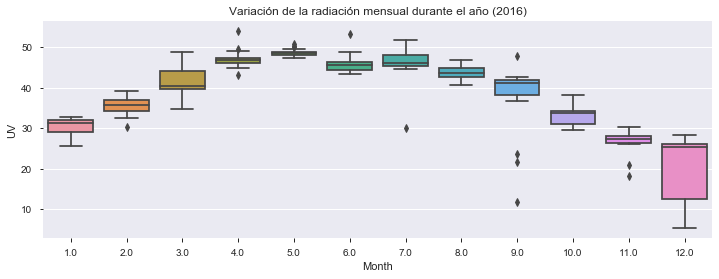

In [18]:
position  = np.arange(1,13,1)
monthDict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df = df_Ali_2016_daytime_Daily_Max

fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x="Month",y='UV',data=df,ax=ax)
plt.title("Variación de la radiación mensual durante el año (2016)")
plt.show()


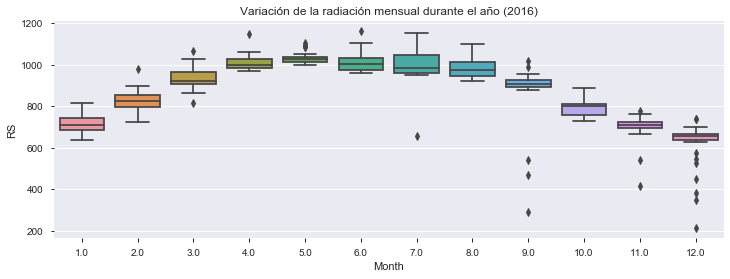

In [19]:
df = df_Ali_2016_daytime_Daily_Max

fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='Month',y='RS',data=df,ax=ax)
plt.title("Variación de la radiación mensual durante el año (2016)")
plt.show()

In [267]:
# Describe overview of resulting work dataframe
#pandas_profiling.ProfileReport(df_Ali)

## Read Met data file

In [20]:
df_Costa_Hillo3 = pd.read_csv("Costa_Hillo_3.csv", sep=";", engine="python")
df_Costa_Hillo3.head()

,Estaci�n,Clave,Latitud,Longitud,fecha_hora,fecha,hora_minuto,hora,tp,tmax,tmin,hr,rs
0,GREEN STRIPE,EMA-26030-06,29.090817,-111.561448,9/12/13 13:40,9/12/13,13:40:00,13,38.56,38.91,38.33,28.11,798.88
1,GREEN STRIPE,EMA-26030-06,29.090817,-111.561448,9/12/13 13:50,9/12/13,13:50:00,13,38.65,39.06,38.17,27.52,844.40
2,GREEN STRIPE,EMA-26030-06,29.090817,-111.561448,9/12/13 14:00,9/12/13,14:00:00,14,38.62,39.01,38.28,27.31,826.73
3,GREEN STRIPE,EMA-26030-06,29.090817,-111.561448,9/12/13 14:10,9/12/13,14:10:00,14,38.83,39.04,38.44,27.36,800.98
4,GREEN STRIPE,EMA-26030-06,29.090817,-111.561448,9/12/13 14:20,9/12/13,14:20:00,14,38.79,39.01,38.43,27.30,778.22


In [21]:
# Extract data from 'La Bachata' station
df_Bachata_dist = df_Costa_Hillo3[df_Costa_Hillo3['Estaci�n'] == 'LA BACHATA']
df_Bachata_dist = df_Bachata_dist.reset_index(drop=True)
df_Bachata_dist.to_csv("Bachata_dist.csv", sep=';')
df_Bachata_dist.head()

,Estaci�n,Clave,Latitud,Longitud,fecha_hora,fecha,hora_minuto,hora,tp,tmax,tmin,hr,rs
0,LA BACHATA,EMA-26030-11,28.96421,-111.1319,12/25/15 5:50,12/25/15,5:50:00,5,9.76,9.88,9.61,92.18,0.29
1,LA BACHATA,EMA-26030-11,28.96421,-111.1319,12/25/15 6:00,12/25/15,6:00:00,6,9.76,9.88,9.61,92.18,0.29
2,LA BACHATA,EMA-26030-11,28.96421,-111.1319,12/25/15 6:10,12/25/15,6:10:00,6,10.01,10.13,9.87,91.65,0.29
3,LA BACHATA,EMA-26030-11,28.96421,-111.1319,12/25/15 6:20,12/25/15,6:20:00,6,9.92,10.13,9.67,91.58,0.29
4,LA BACHATA,EMA-26030-11,28.96421,-111.1319,12/25/15 6:30,12/25/15,6:30:00,6,9.83,10.06,9.67,91.50,0.29


In [22]:
# Drop first 4 unnecesary columns
df_Bachata_tmp = df_Bachata_dist.copy()
df_Bachata_tmp.drop(df_Bachata_tmp.iloc[:,0:4], inplace=True, axis=1)

# Create nDate and nTime columns similar to df_Ali dataframe
df_Bachata_tmp['nDate'] = pd.to_datetime(df_Bachata_tmp['fecha'], errors='coerce', format='%m/%d/%y').dt.strftime('%Y-%m-%d')
df_Bachata_tmp['nTime'] = pd.to_datetime(df_Bachata_tmp['hora_minuto'], errors='coerce', format='%H:%M:%S').dt.strftime('%H:%M')

# Drop old time references no longer needed 
df_Bachata_tmp.drop(df_Bachata_tmp.iloc[:,0:4], inplace=True, axis=1)

df_Bachata_tmp.head()


,tp,tmax,tmin,hr,rs,nDate,nTime
0,9.76,9.88,9.61,92.18,0.29,2015-12-25,05:50
1,9.76,9.88,9.61,92.18,0.29,2015-12-25,06:00
2,10.01,10.13,9.87,91.65,0.29,2015-12-25,06:10
3,9.92,10.13,9.67,91.58,0.29,2015-12-25,06:20
4,9.83,10.06,9.67,91.50,0.29,2015-12-25,06:30


In [41]:
# Continue preparing working dataframe
df_Bachata_work = df_Bachata_tmp.copy()
# Join nDate and nTime into nr¡ew column
df_Bachata_work['Date'] = pd.to_datetime(df_Bachata_work['nDate'] + ' ' + df_Bachata_work['nTime'])
# Drop columns nDate and nTime no longer needed
df_Bachata_work.drop(['nDate', 'nTime'], inplace=True, axis=1)

cols = ['tp', 'tmax', 'tmin']
df_Bachata_work[cols] = df_Bachata_work[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df_Bachata_work.rename(columns={'tp': 'Tp', 'tmax': 'Tmax', 'tmin': 'Tmin', 'hr': 'HR', 'rs': 'SolRad'}, inplace=True)

# Eliminate duplicates
N_before = df_Bachata_work.shape[0]
df_Bachata_work.drop_duplicates(keep=False, inplace=True)
N_after = df_Bachata_work.shape[0]
print(N_before - N_after,' Duplicate rows dropped from Bachata')

# Drop rows with null: UV, RS-CM6-A
df_Bachata_work = df_Bachata_work.loc[~((df_Bachata_work['Tp'].isnull()))]
df_Bachata_work = df_Bachata_work.loc[~((df_Bachata_work['Tmax'].isnull()))]
df_Bachata_work = df_Bachata_work.loc[~((df_Bachata_work['Tmin'].isnull()))]
df_Bachata_work = df_Bachata_work.loc[~((df_Bachata_work['HR'].isnull()))]
df_Bachata_work = df_Bachata_work.loc[~((df_Bachata_work['SolRad'].isnull()))]

# Final working dataframe
df_Bachata_work.head()

# Long compilation time... 


0  Duplicate rows dropped from Bachata


,Tp,Tmax,Tmin,HR,SolRad,Date
0,9.76,9.88,9.61,92.18,0.29,2015-12-25 05:50:00
1,9.76,9.88,9.61,92.18,0.29,2015-12-25 06:00:00
2,10.01,10.13,9.87,91.65,0.29,2015-12-25 06:10:00
3,9.92,10.13,9.67,91.58,0.29,2015-12-25 06:20:00
4,9.83,10.06,9.67,91.50,0.29,2015-12-25 06:30:00


In [42]:

# Create Month, Day, Hour of day column
df_Bachata_work['Month'] = df_Bachata_work['Date'].dt.month
df_Bachata_work['Day'] = df_Bachata_work['Date'].dt.day
df_Bachata_work['Hour'] = df_Bachata_work['Date'].dt.hour

df_Bachata = df_Bachata_work.copy()

# Final working dataframe
df_Bachata.head()


,Tp,Tmax,Tmin,HR,SolRad,Date,Month,Day,Hour
0,9.76,9.88,9.61,92.18,0.29,2015-12-25 05:50:00,12,25,5
1,9.76,9.88,9.61,92.18,0.29,2015-12-25 06:00:00,12,25,6
2,10.01,10.13,9.87,91.65,0.29,2015-12-25 06:10:00,12,25,6
3,9.92,10.13,9.67,91.58,0.29,2015-12-25 06:20:00,12,25,6
4,9.83,10.06,9.67,91.50,0.29,2015-12-25 06:30:00,12,25,6


In [43]:
# Filter year 2016 data
df_Bachata_2016 = df_Bachata[(df_Bachata['Date'] > '2015-12-31 23:59:00' ) & (df_Bachata['Date'] < '2016-12-31 23:59:00')]
print('df_Bachata_2016.shape', df_Bachata_2016.shape)
# Filter daylight data: 6AM - 6PM
df_Bachata_2016_daytime = df_Bachata_2016[(df_Bachata_2016['Hour'] >= 6.0 ) & (df_Bachata_2016['Hour'] <= 18.0)]
print('df_Bachata_2016_daytime.shape', df_Bachata_2016_daytime.shape)


df_Bachata_2016.shape (52182, 9)
df_Bachata_2016_daytime.shape (28252, 9)


In [44]:
# Compute Radiation values hourly averages
df_Bachata_2016_daytime_Hourly_Avg = round(df_Bachata_2016_daytime.groupby(['Month', 'Day', 'Hour']).aggregate(np.mean),2).reset_index()
print("\n Hourly Avg shape:", df_Bachata_2016_daytime_Hourly_Avg.shape)
print(df_Bachata_2016_daytime_Hourly_Avg.head())

# Group data by Month and Day
df_Bachata_2016_daytime_Daily_Max = df_Bachata_2016_daytime.groupby(["Month", "Day"])['Tp', 'Tmax', 'Tmin', 'HR', 'SolRad'].aggregate(np.max).reset_index()
print("\n Daily Max shape:", df_Bachata_2016_daytime_Daily_Max.shape)
print(df_Bachata_2016_daytime_Daily_Max.head())



 Hourly Avg shape: (4758, 8)
   Month  Day  Hour     Tp   Tmax   Tmin     HR  SolRad
0      1    1     6   1.70   2.05   1.37  78.94    0.29
1      1    1     7   1.49   1.98   1.11  81.99   23.58
2      1    1     8   5.53   6.53   4.44  68.43  173.38
3      1    1     9  11.11  12.00  10.40  48.14  331.63
4      1    1    10  15.48  16.24  14.64  36.65  483.22

 Daily Max shape: (366, 7)
   Month  Day     Tp   Tmax   Tmin     HR  SolRad
0      1    1  23.26  23.58  22.99  84.38  620.73
1      1    2  25.52  25.98  25.14  75.91  604.51
2      1    3  26.16  26.43  25.88  82.48  612.91
3      1    4  23.96  24.35  23.61  94.67  642.45
4      1    5  21.46  21.97  21.25  99.04  699.52


## Merging dataframes

In [48]:
# Merging dataframes: left(Bachata) + right(Ali) on Month+Day+Hour

print('df_Ali_2016_daytime_Hourly_Avg.shape', df_Ali_2016_daytime_Hourly_Avg.shape)
print('df_Bachata_2016_daytime_Hourly_Avg.shape', df_Bachata_2016_daytime_Hourly_Avg.shape)
#df_merge = pd.merge(df_Bachata_2016_daytime_Hourly_Avg, df_Ali_2016_daytime_Hourly_Avg, on='Date', how='outer')
df_merge_2016_daytime_Hourly_Avg = pd.merge(df_Bachata_2016_daytime_Hourly_Avg, df_Ali_2016_daytime_Hourly_Avg, on=['Month', 'Day', 'Hour'])
print('df_merge_2016.shape', df_merge_2016.shape)

#result = pd.merge(left, right, on=['key1', 'key2'])

df_Ali_2016_daytime_Hourly_Avg.shape (4637, 5)
df_Bachata_2016_daytime_Hourly_Avg.shape (4758, 8)
df_merge_2016.shape (4637, 10)


In [51]:
df_merge_2016_daytime_Hourly_Avg.head()

,Month,Day,Hour,Tp,Tmax,Tmin,HR,SolRad,UV,RS
0,1,1,6,1.70,2.05,1.37,78.94,0.29,0.00,0.00
1,1,1,7,1.49,1.98,1.11,81.99,23.58,0.49,12.93
2,1,1,8,5.53,6.53,4.44,68.43,173.38,5.14,153.12
3,1,1,9,11.11,12.00,10.40,48.14,331.63,12.66,342.72
4,1,1,10,15.48,16.24,14.64,36.65,483.22,16.86,427.34


In [52]:
# Merging dataframes: left(Bachata) + right(Ali) on Month+Day+Hour

print('df_Ali_2016_daytime_Daily_Max.shape', df_Ali_2016_daytime_Daily_Max.shape)
print('df_Bachata_2016_daytime_Daily_Max.shape', df_Bachata_2016_daytime_Daily_Max.shape)
#df_merge = pd.merge(df_Bachata_2016_daytime_Hourly_Avg, df_Ali_2016_daytime_Hourly_Avg, on='Date', how='outer')
df_merge_2016_daytime_Daily_Max = pd.merge(df_Bachata_2016_daytime_Daily_Max, df_Ali_2016_daytime_Daily_Max, on=['Month', 'Day'])
print('df_merge_2016_daytime_Daily_Max.shape', df_merge_2016_daytime_Daily_Max.shape)

#result = pd.merge(left, right, on=['key1', 'key2'])

df_Ali_2016_daytime_Daily_Max.shape (357, 4)
df_Bachata_2016_daytime_Daily_Max.shape (366, 7)
df_merge_2016_daytime_Daily_Max.shape (357, 9)


In [53]:
df_merge_2016_daytime_Daily_Max.head()

,Month,Day,Tp,Tmax,Tmin,HR,SolRad,UV,RS
0,1,1,23.26,23.58,22.99,84.38,620.73,27.97,654.6
1,1,2,25.52,25.98,25.14,75.91,604.51,28.19,638.3
2,1,3,26.16,26.43,25.88,82.48,612.91,28.55,646.7
3,1,4,23.96,24.35,23.61,94.67,642.45,31.02,709.0
4,1,5,21.46,21.97,21.25,99.04,699.52,26.62,713.0


In [55]:
# Write merged dataframes to CSV (comma separated values) files
df_merge_2016_daytime_Hourly_Avg.to_csv('PromediosPorHora2016.csv', sep=',')
df_merge_2016_daytime_Daily_Max.to_csv('MaximosDiarios2016.csv', sep=',')